In [1]:
############ library  as tf
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import re
from PIL import Image
import shutil
# import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt


print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


In [4]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [5]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="softmax"):
		# 인풋 이미지의 차원과, 채널에 해당하는 축을 설정하여 모델을 초기화합니다
		# "channels_last"는 채널의 축이 마지막에 오는 것을 의미합니다
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
 
 		# 만약 "channels_first"를 사용한다면, 인풋 이미지의 차원을
		# 그에 맞게 바꿔줍니다
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

    # CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
  

    # (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
 
		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
  

    # FC => RELU
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
 
 		# 단일 라벨 분류는 *softmax* 활성화 함수를 사용합니다
		# 다중 라벨 분류는 *sigmoid* 활성화 함수를 사용합니다
		model.add(Dense(classes))
		model.add(Activation(finalAct))
 
 		# 네트워크 아키텍처를 반환합니다
		return model

In [ ]:
!pip install opencv

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [66]:
import matplotlib
matplotlib.use("Agg")
 
# 필요한 패키지들을 가져옵니다
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
# from pyimagesearch.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip -qq "/content/drive/MyDrive/이게뭐약/AI/색깔모양분류/colorimg.zip"

In [ ]:
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True, help="path to input dataset (i.e., directory of images)")
# ap.add_argument("-m", "--model", required=True, help="path to output model")
# ap.add_argument("-l", "--labelbin", required=True, help="path to output label binarizer")
# ap.add_argument("-p", "--plot", type=str, default="plot.png", help="path to output accuracy/loss plot")
# args = vars(ap.parse_args())

In [10]:
import easydict
 
args = easydict.EasyDict({
        "dataset": True,
        "model": True,
        "labelbin": True,
        "plot": "plot.jpg"

})

In [29]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [12]:
# 이미지 경로를 섞어줍니다
print("[INFO] loading images...")
imagePaths = "/content/colorimg"
# random.seed(42)
# random.shuffle(imagePaths)
 
# 데이터와 라벨을 초기화합니다
data = []
labels = []

[INFO] loading images...


In [13]:
file_list = os.listdir(imagePaths)

In [14]:
file_list

['원형_하양-200612728.jpg',
 '장방형_빨강-198500049.jpg',
 '원형_노랑-200606617.jpg',
 '원형_하양-198700309.jpg',
 '장방형_하양-198300344.jpg',
 '장방형_하양-200702513.jpg',
 '원형_초록-200603872.jpg',
 '원형_하양-200000613.jpg',
 '원형_하양-200802220.jpg',
 '장방형_하양-199601061.jpg',
 '원형_하양-200410511.jpg',
 '장방형_연두-199600199.jpg',
 '사각형_노랑-200009063.jpg',
 '타원형_노랑-200400219.jpg',
 '장방형_하양-200400322.jpg',
 '원형_하양-200511125.jpg',
 '원형_하양-200410070.jpg',
 '장방형_갈색-198900528.jpg',
 '원형_하양-199701269.jpg',
 '타원형_노랑-200300286.jpg',
 '원형_노랑-199300959.jpg',
 '타원형_파랑-200300898.jpg',
 '장방형_하양-200600055.jpg',
 '장방형_파랑-199700942.jpg',
 '원형_하양-200009077.jpg',
 '장방형_연두-200410502.jpg',
 '원형_하양-199900349.jpg',
 '장방형_파랑-200000803.jpg',
 '원형_주황-200500476.jpg',
 '장방형_초록-200400143.jpg',
 '원형_주황-200702734.jpg',
 '타원형_노랑-200511380.jpg',
 '오각형_분홍-199700553.jpg',
 '타원형_하양-200300277.jpg',
 '장방형_갈색, 투명-200500431.jpg',
 '타원형_하양-200502773.jpg',
 '원형_하양-199800514.jpg',
 '장방형_빨강-200400372.jpg',
 '타원형_노랑-200600080.jpg',
 '장방형_하양-199602451.jpg',
 '장방형_분홍-199

In [27]:
file_list[9].split("-")[0].split("_")

['장방형', '하양']

In [42]:
# 인풋 이미지들에 대해 아래의 반복문을 수행합니다
for imagePath in file_list:
  image = cv2.imread('./colorimg/'+imagePath)
  # print(image)
  image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
  image = img_to_array(image)
  data.append(image)
 
 	# # # 이미지 경로에서 라벨을 추출한 후, 라벨 리스트를 업데이트합니다
  l = label = imagePath.split("-")[0].split("_")
  labels.append(l)

In [43]:
labels

[['원형', '하양'],
 ['장방형', '빨강'],
 ['원형', '노랑'],
 ['원형', '하양'],
 ['장방형', '하양'],
 ['장방형', '하양'],
 ['원형', '초록'],
 ['원형', '하양'],
 ['원형', '하양'],
 ['장방형', '하양'],
 ['원형', '하양'],
 ['장방형', '연두'],
 ['사각형', '노랑'],
 ['타원형', '노랑'],
 ['장방형', '하양'],
 ['원형', '하양'],
 ['원형', '하양'],
 ['장방형', '갈색'],
 ['원형', '하양'],
 ['타원형', '노랑'],
 ['원형', '노랑'],
 ['타원형', '파랑'],
 ['장방형', '하양'],
 ['장방형', '파랑'],
 ['원형', '하양'],
 ['장방형', '연두'],
 ['원형', '하양'],
 ['장방형', '파랑'],
 ['원형', '주황'],
 ['장방형', '초록'],
 ['원형', '주황'],
 ['타원형', '노랑'],
 ['오각형', '분홍'],
 ['타원형', '하양'],
 ['장방형', '갈색, 투명'],
 ['타원형', '하양'],
 ['원형', '하양'],
 ['장방형', '빨강'],
 ['타원형', '노랑'],
 ['장방형', '하양'],
 ['장방형', '분홍'],
 ['타원형', '하양'],
 ['원형', '하양'],
 ['원형', '노랑'],
 ['원형', '하양'],
 ['마름모형', '하양'],
 ['원형', '하양'],
 ['원형', '하양'],
 ['기타', '초록'],
 ['원형', '초록'],
 ['장방형', '갈색, 투명'],
 ['타원형', '빨강'],
 ['원형', '하양'],
 ['원형', '노랑'],
 ['원형', '하양'],
 ['타원형', '주황'],
 ['원형', '하양'],
 ['장방형', '주황'],
 ['기타', '하양'],
 ['원형', '하양'],
 ['원형', '파랑'],
 ['원형', '하양'],
 ['원형', '하양'],
 ['장방형', '회색'],

In [45]:
# 모든 픽셀 값이 [0, 1]의 범위 내에 오도록 변환합니다 
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(file_list), data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 1007 images (217.51MB)


In [46]:
# scikit-learn의 다중 라벨 이진화 함수를 사용해 라벨을 이진화 합니다
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
 
# 나올 수 있는 모든 라벨들을 출력합니다
for (i, label) in enumerate(mlb.classes_):
  print("{}. {}".format(i + 1, label))

[INFO] class labels:
1. 갈색
2. 갈색, 투명
3. 검정
4. 기타
5. 노랑
6. 노랑, 투명
7. 마름모형
8. 보라
9. 분홍
10. 빨강
11. 빨강, 투명
12. 사각형
13. 삼각형
14. 연두
15. 오각형
16. 원형
17. 육각형
18. 자주
19. 장방형
20. 주황
21. 청록
22. 초록
23. 타원형
24. 파랑
25. 팔각형
26. 하양
27. 회색


In [47]:
mlb.transform([("원형", "노랑")])

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0]])

In [48]:
# 데이터의 80%를 학습에, 나머지 20%를 테스트에 사용하기 위해
# 데이터를 나누는 과정입니다
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)
 
# 이미지 오그멘테이션을 위한 제너레이터를 초기화합니다
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [49]:
# 다중 라벨 분류를 수행할 수 있도록 sigmoid 활성화 함수를
# 네트워크의 마지막 레이어로 설정합니다
print("[INFO] compiling model...")
model = SmallerVGGNet.build(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="sigmoid")

# 옵티마이저를 초기화합니다
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

[INFO] compiling model...


In [50]:
# 각각의 결과 라벨을 독립적인 베르누이 분포로 취급하기 위해
# 범주형 교차 엔트로피 대신 이진 교차 엔트로피를 사용하여 모델을 컴파일합니다
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
 
# 네트워크를 학습시킵니다
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
25/25 [==============================] - 36s 96ms/step - loss: 0.8964 - accuracy: 0.0973 - val_loss: 0.5755 - val_accuracy: 0.3366
Epoch 2/75
25/25 [==============================] - 2s 70ms/step - loss: 0.6657 - accuracy: 0.1496 - val_loss: 0.4407 - val_accuracy: 0.3366
Epoch 3/75
25/25 [==============================] - 2s 71ms/step - loss: 0.4956 - accuracy: 0.1375 - val_loss: 0.3334 - val_accuracy: 0.3366
Epoch 4/75
25/25 [==============================] - 2s 73ms/step - loss: 0.2971 - accuracy: 0.1717 - val_loss: 0.2664 - val_accuracy: 0.3366
Epoch 5/75
25/25 [==============================] - 2s 72ms/step - loss: 0.1964 - accuracy: 0.1750 - val_loss: 0.2256 - val_accuracy: 0.3366
Epoch 6/75
25/25 [==============================] - 2s 74ms/step - loss: 0.1619 - accuracy: 0.2212 - val_loss: 0.2411 - val_accuracy: 0.3366
Epoch 7/75
25/25 [==============================] - 2s 74ms/step - loss: 0.1408 - accuracy: 0.2379 - val_loss: 0.2401 - val_accuracy: 0.3366
Epoch 8/75
2

In [86]:
# 모델을 디스크에 저장합니다
from keras.models import load_model

model.save('multilabel_model.h5')

# print("[INFO] serializing network...")
# model.save(args["model"])
 
# `MultiLabelBinarizer`를 디스크에 저장합니다
print("[INFO] serializing label binarizer...")
f = open('/content/labelbin.txt', "wb")
f.write(pickle.dumps(mlb))
f.close()

[INFO] serializing label binarizer...


In [61]:
H.history

{'accuracy': [0.10090555995702744,
  0.1487710177898407,
  0.1487710177898407,
  0.16300129890441895,
  0.177231565117836,
  0.22875000536441803,
  0.22121603786945343,
  0.2626132071018219,
  0.23803363740444183,
  0.28331178426742554,
  0.2729624807834625,
  0.2626132071018219,
  0.28999999165534973,
  0.26002585887908936,
  0.27037516236305237,
  0.30530402064323425,
  0.2794307768344879,
  0.30250000953674316,
  0.263906866312027,
  0.30142301321029663,
  0.291073739528656,
  0.32341527938842773,
  0.2690815031528473,
  0.2794307768344879,
  0.291073739528656,
  0.3247089385986328,
  0.2626132071018219,
  0.2923673987388611,
  0.28719276189804077,
  0.28719276189804077,
  0.2962483763694763,
  0.240620955824852,
  0.30530402064323425,
  0.2923673987388611,
  0.3195342719554901,
  0.3298835754394531,
  0.2988356947898865,
  0.2755497992038727,
  0.2846054434776306,
  0.3499999940395355,
  0.3156532943248749,
  0.3078913390636444,
  0.32875001430511475,
  0.3208279311656952,
  0.3557

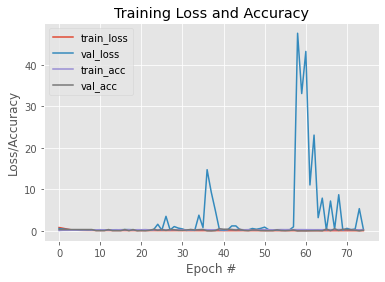

<Figure size 432x288 with 0 Axes>

In [70]:
from matplotlib import pyplot as plt
%matplotlib inline
# 학습 로스와 정확도를 그래프로 그려줍니다
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()
plt.savefig(args["plot"])

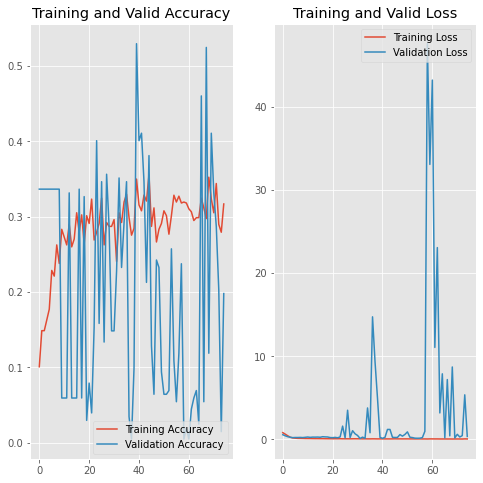

In [72]:
# loss, acc curve

acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

새로운 이미지에 적용

In [144]:
# 필요한 패키지들을 가져옵니다
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image

In [169]:
def test(img_dir):
  
  # 이미지를 로드합니다
  image = cv2.imread(img_dir)
  output = imutils.resize(image, width=400)
  
  # 분류를 위한 이미지 전처리를 수행합니다
  image = cv2.resize(image, (96, 96))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  # 학습된 네트워크와 `MultiLabelBinarizer`를 로드합니다
  print("[INFO] loading network...")
  model = load_model('/content/multilabel_model.h5')
  mlb = pickle.loads(open('/content/labelbin.txt', "rb").read())

  # 이미지에 대한 분류를 수행한 후, 
  # 확률이 가장 높은 두 개의 클래스 라벨을 찾습니다
  print("[INFO] classifying image...")
  proba = model.predict(image)[0]
  idxs = np.argsort(proba)[::-1][:2]

  # 확률이 높은 라벨들에 대해 아래의 반복문을 수행합니다
  output = Image.fromarray(image)
  draw = ImageDraw.Draw(output)

  for (i, j) in enumerate(idxs):
    # 이미지 위에 라벨을 덧씌웁니다
    text = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    # cv2.putText(output, label, (10, (i * 30) + 25), 
    #   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    draw.text((30,50), text, font = ImageFont.truetype("fonts/gulim.ttc",20), fill =(255,255,255))

  # print(label)
  # 각 라벨에 대한 확률을 출력합니다
  for (label, p) in zip(mlb.classes_, proba):
    print("{}: {:.2f}%".format(label, p * 100))
 
  # 결과 이미지를 출력합니다
  cv2_imshow(output)
  cv2.waitKey(0)


In [ ]:
test('/content/test/out2.png')

In [ ]:
#png 파일 있으면 jpg 로 변환해주기

for sampleimg in listdir :
  if os.path.splitext(sampleimg)[-1] == '.png':
    im = Image.open(data_dir + '/'+sampleimg)
    im = im.convert("RGB")
    im.save(data_dir + '/'+'%s.jpg'%os.path.splitext(sampleimg)[0])
    print(sampleimg)
    os.remove(data_dir + '/'+sampleimg)

